In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import pathlib

In [4]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [7]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28)), 
    keras.layers.Reshape(target_shape=(28, 28, 1)), 
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation = tf.nn.relu), 
    keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    keras.layers.Flatten(), 
    keras.layers.Dense(10)
])

2023-08-18 19:27:17.262316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/rolling/opt/rviz_ogre_vendor/lib:/opt/ros/rolling/lib/x86_64-linux-gnu:/opt/ros/rolling/lib
2023-08-18 19:27:17.262384: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 19:27:17.262419: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mhmud): /proc/driver/nvidia/version does not exist
2023-08-18 19:27:17.263101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
             metrics=['accuracy'])

In [9]:
model.fit(train_images, train_labels, epochs=1, validation_data=(test_images, test_labels))

2023-08-18 19:29:26.269859: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 15s 8ms/step - loss: 0.3057 - accuracy: 0.9131 - val_loss: 0.1452 - val_accuracy: 0.9572


In [10]:
model.save('mnist_without_opt.h5')

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9fvnu2zr/assets


INFO:tensorflow:Assets written to: /tmp/tmp9fvnu2zr/assets
2023-08-18 19:45:29.180073: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-08-18 19:45:29.180102: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-08-18 19:45:29.180240: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9fvnu2zr
2023-08-18 19:45:29.182036: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-18 19:45:29.182073: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9fvnu2zr
2023-08-18 19:45:29.188367: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-08-18 19:45:29.232639: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9fvnu2zr
2023-08-18 19:45:29.242116: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [12]:
tflite_models_dir = pathlib.Path('mnist_tflite_model/')
tflite_models_dir.mkdir()

In [13]:
tflite_model_file = tflite_models_dir/'mnist_model.tflite'
tflite_model_file.write_bytes(tflite_model)

84836

In [14]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.sopported_types = [tf.float16]

In [15]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/'mnist_model_fp16.tflite'
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmp/tmp5rsd1qa3/assets


INFO:tensorflow:Assets written to: /tmp/tmp5rsd1qa3/assets
2023-08-18 19:44:01.291701: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-08-18 19:44:01.291728: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-08-18 19:44:01.291869: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5rsd1qa3
2023-08-18 19:44:01.294033: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-18 19:44:01.294060: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5rsd1qa3
2023-08-18 19:44:01.298291: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-08-18 19:44:01.350784: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5rsd1qa3
2023-08-18 19:44:01.371681: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

24080

In [17]:
interpreter = tf.lite.Interpreter(model_path = str(tflite_model_file))
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [18]:
interpreter_fp16 = tf.lite.Interpreter(model_path = str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

In [21]:
test_images = np.expand_dims(test_images[0], axis=0).astype(np.float32)
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_images)

interpreter.invoke()

predictions = interpreter.get_tensor(output_index)


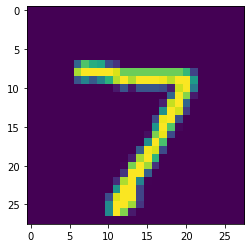

In [22]:
import matplotlib.pyplot as plt
plt.imshow(test_images[0])


In [23]:
np.argmax(predictions[0])

7

In [24]:
test_images = np.expand_dims(test_images[0], axis=0).astype(np.float32)
input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]

interpreter_fp16.set_tensor(input_index, test_images)

interpreter_fp16.invoke()

predictions = interpreter_fp16.get_tensor(output_index)

In [25]:
np.argmax(predictions[0])

7

In [26]:
def evaluate_model(interpreter):
    input_index = interpreter_fp16.get_input_details()[0]["index"]
    output_index = interpreter_fp16.get_output_details()[0]["index"]
    
    prediction_digits = []
    for test_image in test_images:
            test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
            interpreter.set_tensor(input_index, test_images)
            interpreter.invoke()
            predictions = interpreter.get_tensor(output_index)
            digit = np.argmax(predictions)
            prediction_digits.append(digit)
            
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == test_labels[index]:
            accurate_count += 1
    accuracy  = accurate_count/len(prediction_digits)
    return accuracy
    
    

In [27]:
evaluate_model(interpreter)

1.0

In [28]:
evaluate_model(interpreter_fp16)

1.0